In [1]:
import open_clip
import torch
from PIL import Image
from matplotlib import pyplot as plt

/dlabscratch1/dlabscratch1/wendler/.lclip/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Classifying a single image

In [11]:
models = {'B-8': {'model_name':'Latent-ViT-B-8-512',
                  'pretrained':'/dlabdata1/wendler/models/latent-clip-b-8.pt'},
          'B-4-plus':{'model_name':'Latent-ViT-B-4-512-plus',
                      'pretrained':'/dlabdata1/wendler/models/latent-clip-b-4-plus.pt'}}
size = 'B-8'
model_name = models[size]['model_name']
pretrained = models[size]['pretrained']
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

image = preprocess(Image.open("../CLIP.jpg")).unsqueeze(0)
labels = ["a diagram", "a dog", "a cat", "two dogs", "three dogs"]
text = tokenizer(labels)

model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)
print("Pred:", labels[text_probs.argmax()])  

Label probs: tensor([[1.0111e-06, 1.0038e-02, 6.7027e-07, 9.4371e-01, 4.6246e-02]])
Pred: two dogs


# Webdatasets

In [3]:
import webdataset as wds
from dataclasses import dataclass
from training.data import get_wds_dataset

@dataclass
class Args:
    dataset_type: str = "webdataset-latent"
    val_data: str = "/dlabdata1/wendler/data/laicoco-latents-sdxl-f8/aug/000/000/{000000..000081}.tar"
    val_num_samples: int = None
    train_data: str = None
    train_num_samples: int = None
    seed: int = 42
    batch_size: int = 128
    workers: int = 1
    world_size: int = 1
    train_data_upsampling_factors: float = None 

args = Args()
dataset = get_wds_dataset(args, lambda x: x, False, tokenizer=tokenizer)

In [9]:
latents, captions = next(iter(dataset.dataloader))

In [15]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents.cuda().to(torch.bfloat16))
    text_features = model.encode_text(captions.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

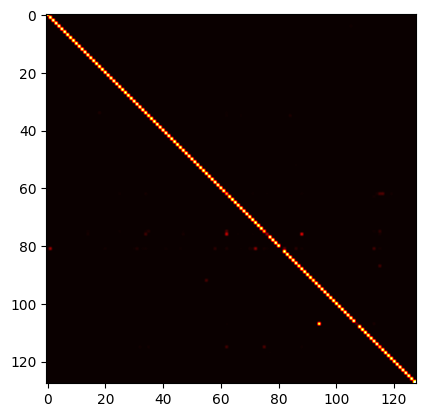

In [19]:
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()